In [17]:
using Pkg
Pkg.activate("../../")
using Combinatorics, SparseArrays, KrylovKit, LinearAlgebra, Plots, LaTeXStrings
theme(:lime)

  Activating project at `c:\Users\saksh\Documents\code-repo\Projects\Thesis`


In [18]:
hilbert_dim(k, n) = binomial(k + n - 1, n - 1)

function generate_basis(N, L)
    if L > 1
        basis = zeros(Int16, (hilbert_dim(N, L), L))
        j = 1
    
        for n in 0:N
            d = hilbert_dim(n, L - 1)
            basis[j:(j + d - 1), 1] .= (N - n)
            basis[j:(j + d - 1), 2:end] = generate_basis(n, L - 1)
            j += d
        end
        
    else
        basis = [N]
    end

    return basis
end

generate_basis (generic function with 1 method)

In [19]:
function hop(state, i, j)
    res_state = copy(state)
    res_state[i] += 1
    res_state[j] -= 1
    return res_state
end

# tags to label the basis states
tag(state) = sum(sqrt.(100 .* (1:length(state)) .+ 3) .* state)
unzip(arr) = map(x -> getfield.(arr, x), fieldnames(eltype(arr)))

function generate_kinetic(t, basis)
    D, L = size(basis)
    basis_tags = tag.(eachslice(basis, dims = 1)) # generate tags for each basis
    inds, basis_tags = sortperm(basis_tags), sort(basis_tags) # sorting tag-list for efficient searching

    H_kin = Dict{Tuple{Int64, Int64}, Float64}() # store sparse values; (index) -> val

    for v in 1:D # iterate through basis vectors
        state = basis[v, :] # get vth basis state 

        for j in 1:L # iterate through states (hopping) 
            if state[j] > 0 
                i = mod1(j + 1, L) # Periodic BC
                u = inds[searchsortedfirst(basis_tags, tag(hop(state, i, j)))]
                H_kin[(u, v)] = get(H_kin, (u, v), 0.) - t * ((state[i] + 1) * state[j]) ^ 0.5
            
                i = mod1(j - 1, L) # Periodic BC
                u = inds[searchsortedfirst(basis_tags, tag(hop(state, i, j)))]
                H_kin[(u, v)] = get(H_kin, (u, v), 0.) - t * ((state[i] + 1) * state[j]) ^ 0.5
            end
        end
    end

    return sparse(unzip(keys(H_kin))..., collect(values(H_kin)))
end

generate_interaction(U, basis) = spdiagm(0.5 .* U .* sum(basis .* (basis .- 1), dims = 2) |> vec)
generate_number(mu, basis) = mu * spdiagm(sum(basis, dims = 2) |> vec)
generate_hamiltonian(t, U, mu, basis) = generate_kinetic(t, basis) + generate_interaction(U, basis) - generate_number(mu, basis)

generate_hamiltonian (generic function with 1 method)

In [20]:
function SPDM(ground_state, basis)    
    D, L = size(basis)
    basis_tags = tag.(eachslice(basis, dims = 1)) # generate tags for each basis
    inds, basis_tags = sortperm(basis_tags), sort(basis_tags) # sorting tag-list to reduce complexity

    SPDM = zeros((L, L))

    for i in 1:L, j in 1:L 
        new_state = zeros(D) # ground state after action of hopping term

        for v in 1:D # iterate over components of the ground state
            state = basis[v, :]
            if state[j] > 0 
                u = inds[searchsortedfirst(basis_tags, tag(hop(state, i, j)))]

                # co-efficient from the hopping term
                if i != j 
                    new_state[u] += ((state[i] + 1) * state[j]) ^ 0.5 * ground_state[v] 
                else
                    new_state[u] += state[i] * ground_state[v] 
                end
            end
        end

        SPDM[i, j] = sum(ground_state .* new_state)
    end

    return SPDM
end

SPDM (generic function with 1 method)

In [21]:
function occupation_variance(ground_state, basis, i)
    D, L = size(basis)
    n_exp = sum(basis[:, i] .* (ground_state .^ 2))
    nsq_exp = sum((basis[:, i] .^ 2).* (ground_state .^ 2))

    return sqrt(nsq_exp - n_exp ^ 2)
end

occupation_variance (generic function with 1 method)

In [27]:
num_particles, num_states = 9, 9
basis = generate_basis(num_particles, num_states);
T = generate_kinetic(1, basis);
V = generate_interaction(1, basis);
N = generate_number(1, basis);

In [28]:
U = 0:0.5:20;
fc = zeros(Float64, length(U));
odlro = zeros(Float64, length(U));
nvar = zeros(Float64, length(U));

In [29]:
for (i, u) in enumerate(U)
    E, vecs = eigsolve(T .+ u * V, 1, :SR)
    ρ = SPDM(vecs[1], basis)

    fc[i] = sum(ρ[1, :]) # largest eigenvalue
    odlro[i] = ρ[1, num_states ÷ 2]
    nvar[i] = occupation_variance(vecs[1], basis, num_states ÷ 2)
end

In [25]:
theme(:dao)

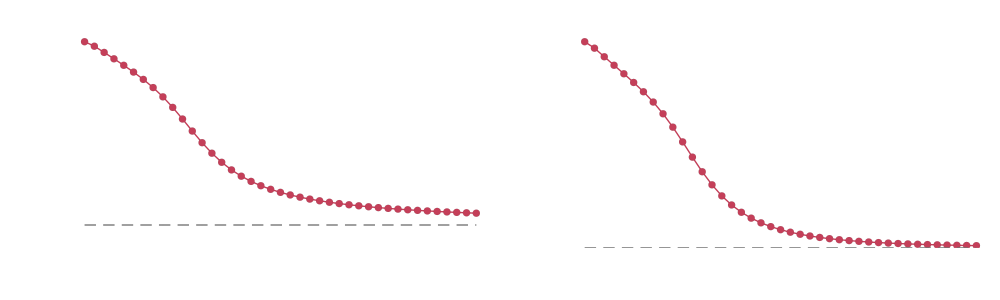

In [30]:
plot(U, fc ./ num_states, st = [:line, :scatter], labels = ["" ""], xlabel = L"$U/t$", ylabel = L"Condensate fraction - $f_c$", c = "#c43f59");
plot!(U, fill(1/num_states, length(U)), ls = :dash, label = "")
p1 = plot!(framestyle = :box, title = "Exact Diagonalization - Phase transition", titlefontsize = 11, ylims = [0., 1.1], legend = :topright);

plot(U, odlro, st = [:line, :scatter], labels = ["" ""], xlabel = L"$U/t$", ylabel = L"Correlation - $\rho_{0,[M/2]}$", c="#c43f59");
plot!(U, zeros(length(U)), ls = :dash, label = "")
p2 = plot!(framestyle = :box, title = "Off-diagonal Long Range Order", titlefontsize = 11, ylims = [0., 1.1], legend=:topright);

plot(p1, p2, size = (1000, 300), left_margin=5Plots.mm, bottom_margin=6Plots.mm, layout = (1, 2), background = :transparent)


In [33]:
plot(U, fc ./ num_states, st = [:line, :scatter], labels = ["" ""], xlabel = L"$U/t$", ylabel = L"Condensate fraction - $f_c$", c = "#c43f59");
plot!(U, fill(1/num_states, length(U)), ls = :dash, label = "")
plot!(framestyle = :box, ylims = [0., 1.1], legend = :topright, background = :transparent, dpi = 300, leftmargin = 5Plots.mm)
savefig("../../../../../thesis/images/ch4/condensate_fraction.png")


In [34]:
plot(U, odlro, st = [:line, :scatter], labels = ["" ""], xlabel = L"$U/t$", ylabel = L"Correlation - $\rho_{0,[M/2]}$", c="#c43f59");
plot!(U, zeros(length(U)), ls = :dash, label = "")
plot!(framestyle = :box, ylims = [0., 1.1], legend=:topright, background = :transparent, leftmargin = 5Plots.mm, dpi = 300)
savefig("../../../../../thesis/images/ch4/odlro.png")

In [36]:
plot(U, nvar, st = [:line, :scatter], labels = ["" ""], xlabel = L"$U/t$", ylabel = L"Occupation variance - $\langle \delta n^2 ⟩$", c = "#c43f59");
plot!(framestyle = :box, ylims = [0., 1.1], legend = :topright, background = :transparent, dpi = 300, leftmargin = 5Plots.mm)
savefig("../../../../../thesis/images/ch4/occupation_var.png")